In [19]:
import numpy as np
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error



import warnings
warnings.filterwarnings('ignore')

In [20]:
df = pd.read_excel('energy_demand.xlsx')
print(df)


            Date  Hour    load          T
0     2012-01-01     0  2872.0  30.666667
1     2012-01-01     1  2698.0  32.000000
2     2012-01-01     2  2558.0  32.666667
3     2012-01-01     3  2444.0  30.000000
4     2012-01-01     4  2402.0  31.000000
...          ...   ...     ...        ...
26300 2014-12-31    20  4012.0  18.000000
26301 2014-12-31    21  3856.0  16.666667
26302 2014-12-31    22  3671.0  17.000000
26303 2014-12-31    23  3499.0  15.333333
26304 2014-12-31    24  3345.0  15.333333

[26305 rows x 4 columns]


In [21]:
# Convert to datetime, considering "24" as "0" of the next day
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Hour'].astype(str) + ':00:00', errors='coerce')

# Adjust the hour for values equal to 24 and increment the date
mask = df['Hour'] == 24
df.loc[mask, 'Datetime'] = pd.to_datetime(df.loc[mask, 'Date'].astype(str) + ' 00:00:00', errors='coerce') + pd.DateOffset(days=1)

# Drop the original columns if needed
df = df.drop(['Date', 'Hour'], axis=1)
df.set_index('Datetime', inplace=True)
print(df.head(300))




                       load          T
Datetime                              
2012-01-01 00:00:00  2872.0  30.666667
2012-01-01 01:00:00  2698.0  32.000000
2012-01-01 02:00:00  2558.0  32.666667
2012-01-01 03:00:00  2444.0  30.000000
2012-01-01 04:00:00  2402.0  31.000000
...                     ...        ...
2012-01-13 07:00:00  3418.0  30.000000
2012-01-13 08:00:00  3681.0  29.333333
2012-01-13 09:00:00  3768.0  29.333333
2012-01-13 10:00:00  3818.0  30.333333
2012-01-13 11:00:00  3856.0  30.666667

[300 rows x 2 columns]


In [23]:
#search for missing values
print(df.isnull().sum())

load    0
T       0
dtype: int64


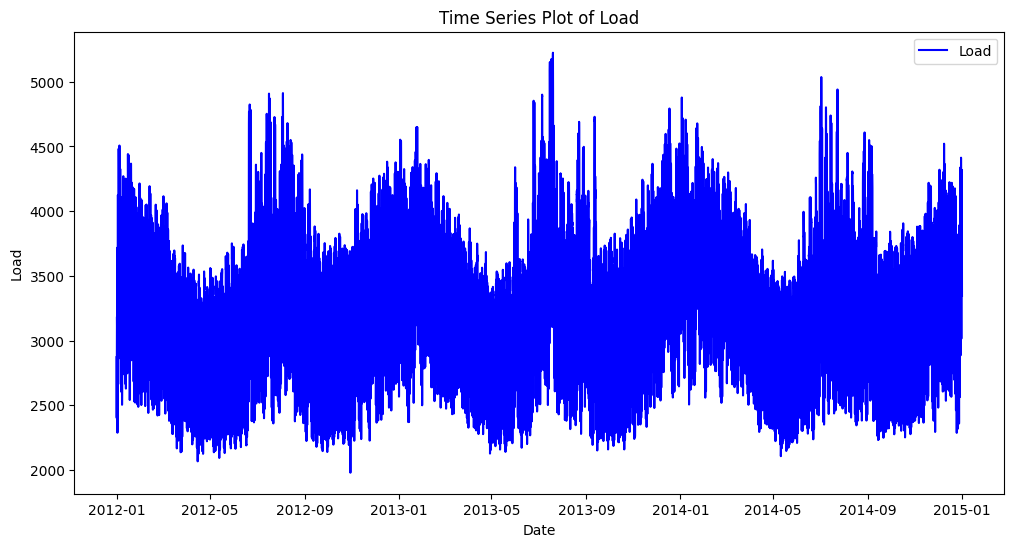

In [4]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df['load'], label='Load', color='blue')
plt.title('Time Series Plot of Load')
plt.xlabel('Date')
plt.ylabel('Load')
plt.legend()
plt.show()

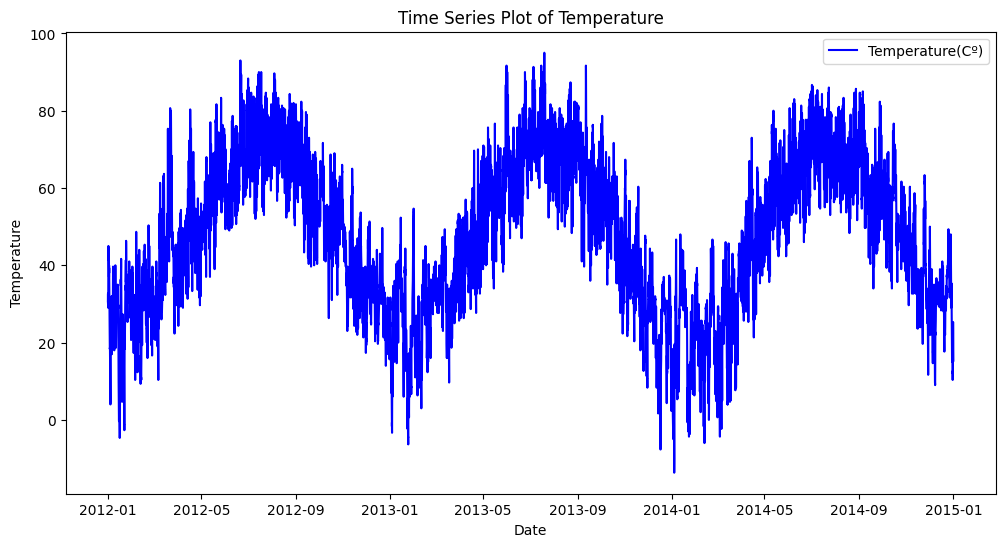

In [5]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot( df['T'], label='Temperature(Cº)', color='blue')
plt.title('Time Series Plot of Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

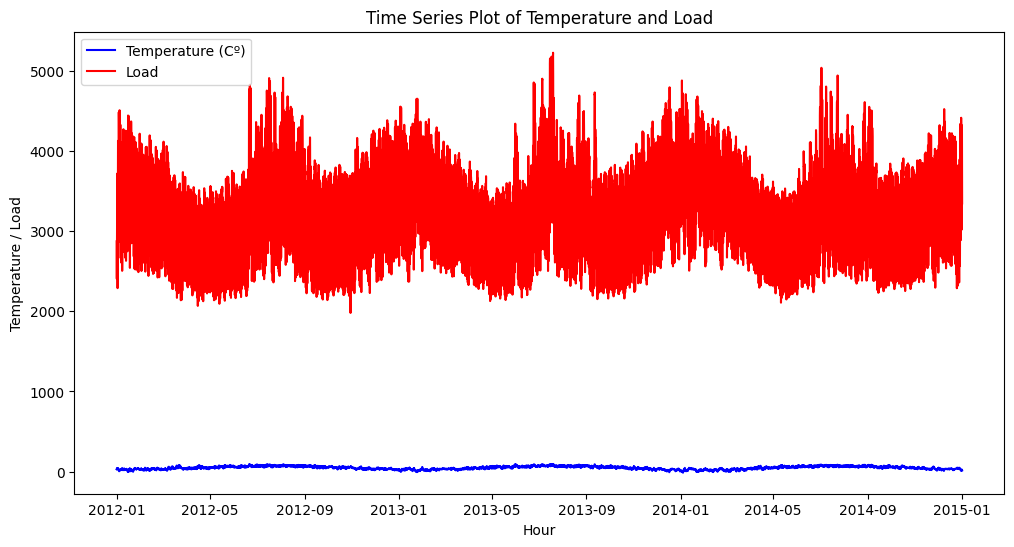

In [6]:
#now let's plot both

plt.figure(figsize=(12, 6))

# Plot both variables on the same scale
plt.plot(df['T'], label='Temperature (Cº)', color='blue')
plt.plot(df['load'], label='Load', color='red')

plt.title('Time Series Plot of Temperature and Load')
plt.xlabel('Hour')
plt.ylabel('Temperature / Load')
plt.legend()
plt.show()

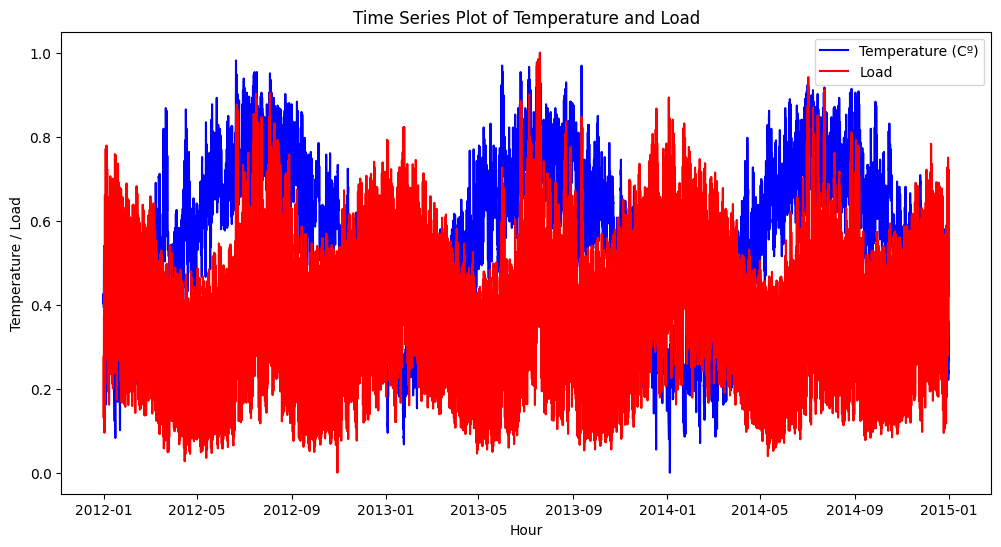

In [7]:
#values are on very different scales, let's normalize and analyze possibel correlation
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_normalized = df.copy()
df_normalized[['load', 'T']] = scaler.fit_transform(df[['load', 'T']])

plt.figure(figsize=(12, 6))

# Plot both variables on the same scale
plt.plot(df_normalized['T'], label='Temperature (Cº)', color='blue')
plt.plot(df_normalized['load'], label='Load', color='red')

plt.title('Time Series Plot of Temperature and Load')
plt.xlabel('Hour')
plt.ylabel('Temperature / Load')
plt.legend()
plt.show()

In [8]:
#let's do the math and check if our variable are correlated

# Check the correlation between "load" and "T" columns
correlation = df_normalized['load'].corr(df['T'])

print(f'Correlation between "load" and "T": {correlation}')

Correlation between "load" and "T": 0.0726679606476381


### RIP, they are not

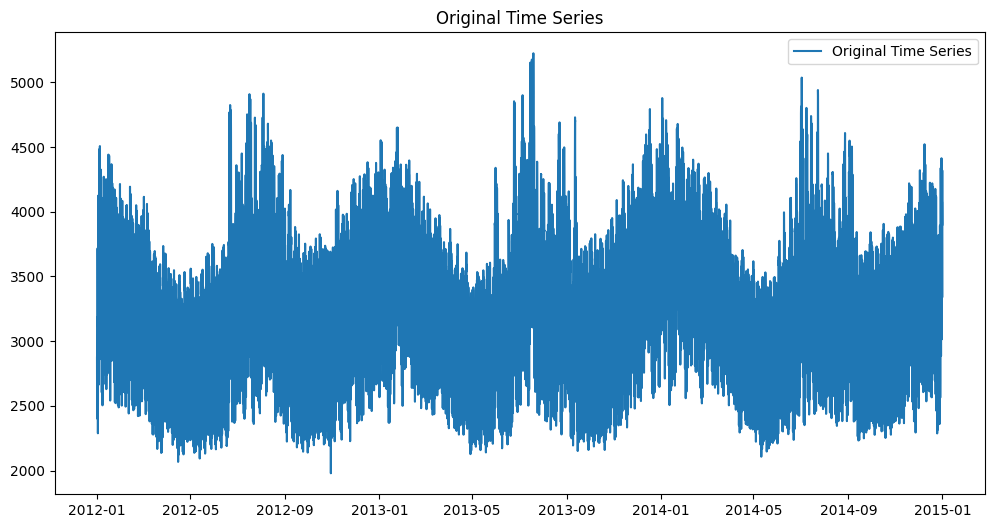

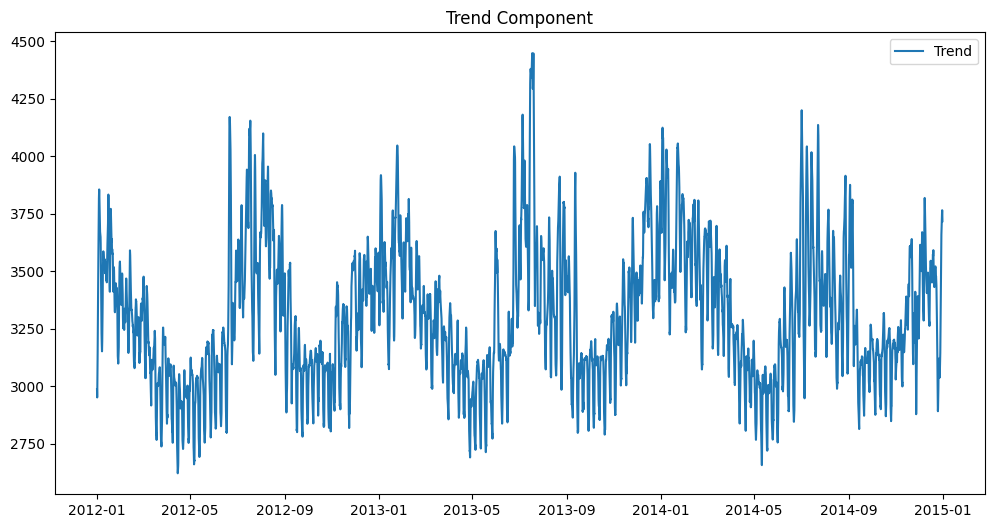

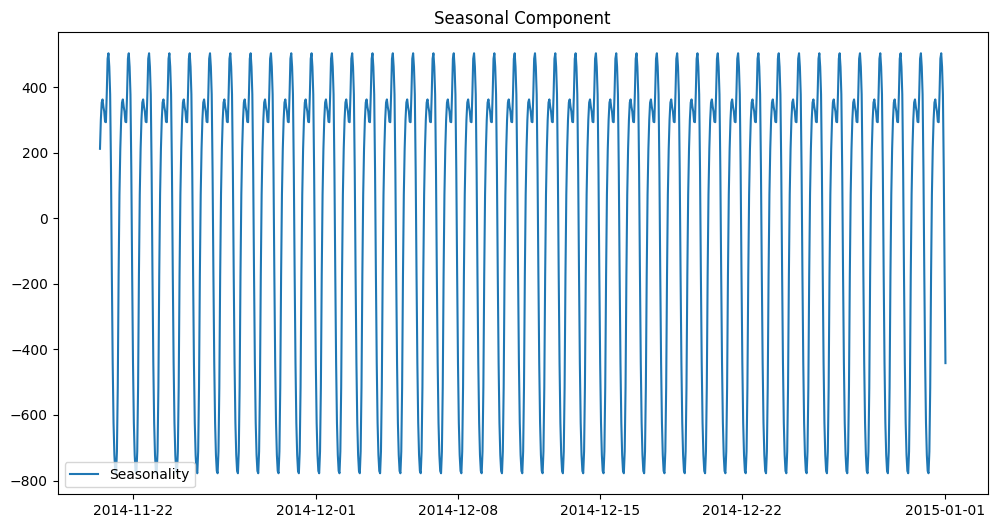

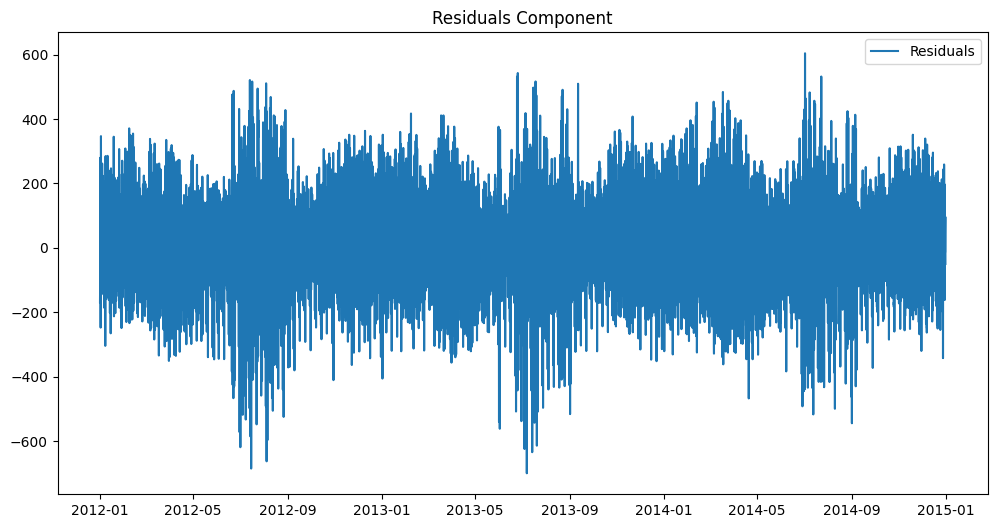

In [9]:


# Use Time series Decomposition (Additive)
components = seasonal_decompose(df['load'], model='additive', period=24)

# Original time series
plt.figure(figsize=(12, 6))
plt.plot(df['load'], label='Original Time Series')
plt.legend()
plt.title('Original Time Series')
plt.show()

# Trend component
plt.figure(figsize=(12, 6))
plt.plot(components.trend, label='Trend')
plt.legend()
plt.title('Trend Component')
plt.show()

# Seasonal component
plt.figure(figsize=(12, 6))
plt.plot(components.seasonal[-1000:], label='Seasonality')
plt.legend()
plt.title('Seasonal Component')
plt.show()

# Residuals component
plt.figure(figsize=(12, 6))
plt.plot(components.resid, label='Residuals')
plt.legend()
plt.title('Residuals Component')
plt.show()

In [10]:


#Ex5 - let's make the series stationary if it isn't already
ADF_result = adfuller(df['load'])



print(f"ADF Statistic: {round(ADF_result[0], 3)}")
print(f"p-value: {round(ADF_result[1], 3)}")

if round(ADF_result[1], 3) < 0.05:
    print('Time Series is Stationary!')
else:
    print('Time Series is not Stationary!')

ADF Statistic: -10.406
p-value: 0.0
Time Series is Stationary!


### Time series is already Stationary (LOAD)

<Figure size 1200x400 with 0 Axes>

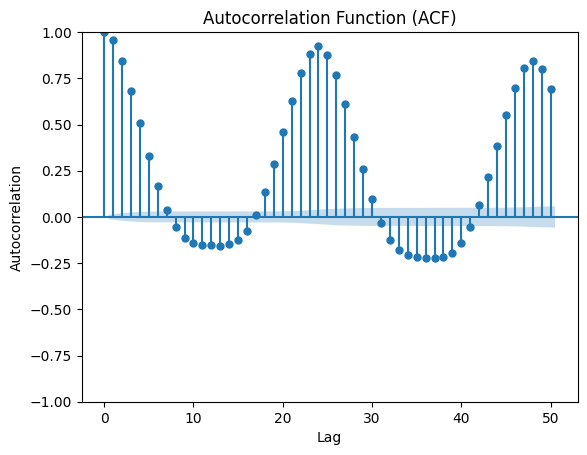

<Figure size 1200x400 with 0 Axes>

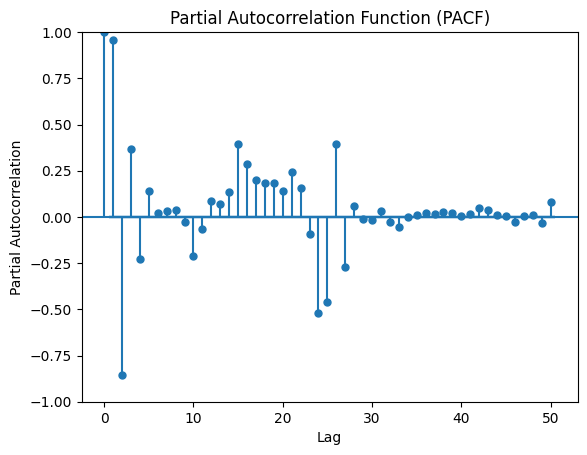

In [11]:
#let's plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



# Plot ACF
plt.figure(figsize=(12, 4))
plot_acf(df['load'], lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 4))
plot_pacf(df['load'], lags=50, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()


In [12]:
from sklearn.preprocessing import StandardScaler


# # Extract the first 50% of the dataset
# half_index = int(len(df) * 0.25)
# data_subset = df.iloc[:half_index]
# print(data_subset)

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['load']])
scaled_data = pd.DataFrame(scaled_data, index=df.index, columns=['load'])

# print(scaled_data)

df_load = df['load']
train_size = len(df_load) - 168
train, test = df_load[:train_size], df_load[train_size:]

In [13]:
# # Define the ranges for your parameters
# p_values = range(3, 9)
# q_values = range(3, 9)

# # Order of differencing
# d = 0

# def evaluate_arima(order, data):
#     try:
#         model = sm.tsa.SARIMAX(data, order=order)
#         print(order)
#         results = model.fit(disp=False)
#         aic = results.aic
#         return aic
#     except:
#         return float('inf')  # Return a large value for combinations that fail

# def grid_search_arima(data, p_values, d, q_values):
#     best_aic = float('inf')
#     best_params = None

#     # Generate all combinations of parameters
#     param_combinations = list(itertools.product(p_values, q_values))

#     for param_set in param_combinations:
#         order = (param_set[0], d, param_set[1])
#         aic = evaluate_arima(order, data)

#         if aic < best_aic:
#             best_aic = aic
#             best_params = param_set

#     return best_params, best_aic

# # Perform grid search
# best_params, best_aic = grid_search_arima(df['load'], p_values, d, q_values)

# print("Best Parameters:", best_params)
# print("Best AIC:", best_aic)

In [16]:
# Define the order obtained from the grid search or any other method
order = (5, 0, 6)  # Replace p, d, q with the best parameters obtained from the grid search

# Fit the ARIMA model on the training data
model = sm.tsa.SARIMAX(train, order=order)
results = model.fit(disp=False, method='powell')

# Make predictions on the test data
predictions = results.get_forecast(steps=len(test))
predicted_values_arima = predictions.predicted_mean


# Calculate and print the Mean Squared Error (MSE) or any other metric for evaluation
mse = ((predicted_values_arima - test) ** 2).mean()
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 290560.0098422545


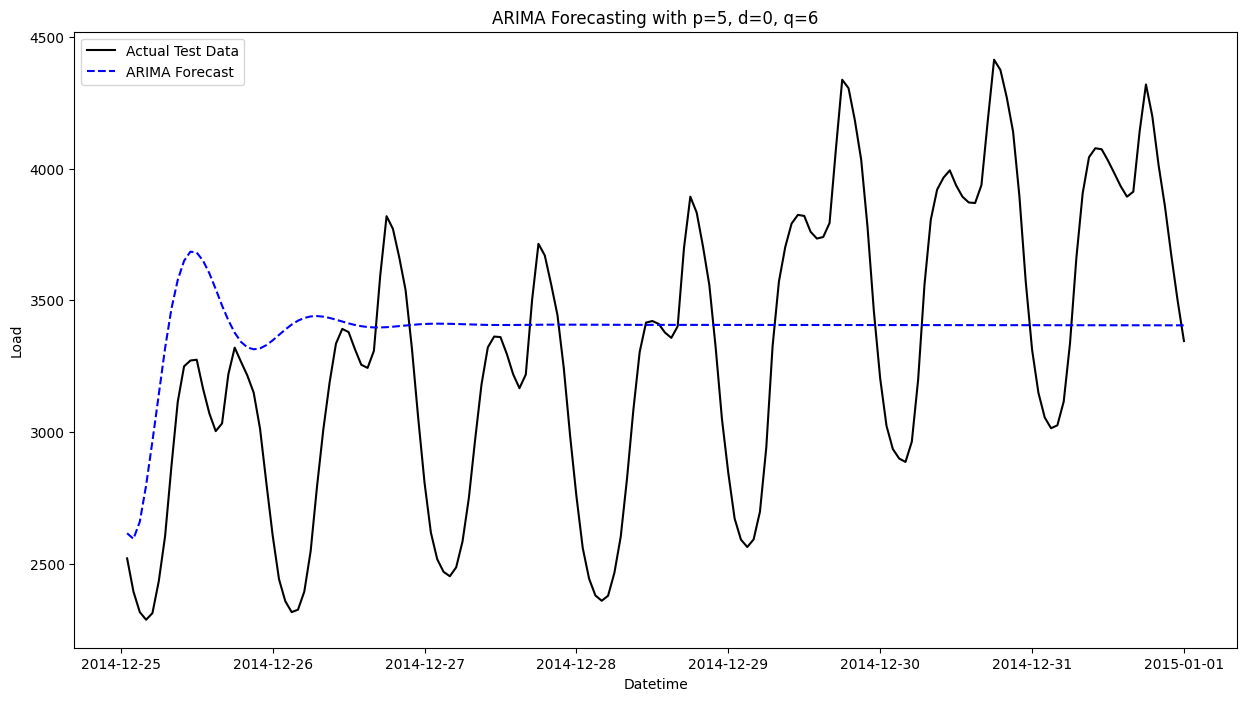

In [17]:
# Plotting actual test data
plt.figure(figsize=(15, 8))

plt.plot(test.index, test, label='Actual Test Data', color='black')

# Plotting forecasts
plt.plot(test.index, predicted_values_arima, label='ARIMA Forecast', linestyle='--', color='blue')

# Customize the plot
plt.title('ARIMA Forecasting with p=5, d=0, q=6')
plt.xlabel('Datetime')
plt.ylabel('Load')
plt.legend()
plt.show()

In [17]:



def rolling_forecast_baseline(function: str, df: pd.DataFrame, train_len: int, horizon: int, window: int) -> list:
   
    if function.lower() == 'mean':
        pred_mean = []

        for i in range(train_len, len(df) + 1, window):
            mean_value = df[i - window:i].mean()  # Replace 'your_column_name' with the actual column name
            pred_mean.extend([mean_value] * window)

        return pred_mean[:168]  # Ensure only 168 predictions are returned

    elif function.lower() == 'last':
        pred_last = []

        for i in range(train_len, len(df) + 1, window):
            last_value = df[i - 1:i].iloc[-1]  # Replace 'your_column_name' with the actual column name
            pred_last.extend([last_value] * window)

        return pred_last[:168]  # Ensure only 168 predictions are returned

    elif function.lower() == 'arima':
        pred_arima = []

        for i in range(train_len, len(df) + 1, window):
            train_data = df[:i]
            
            # Fit ARIMA model on the training data
            model = sm.tsa.SARIMAX(train_data, order=(5,0,6))
            results = model.fit(disp=False)
            
            # Make one-step-ahead forecast
            forecast = results.get_forecast(steps=1)
            pred_value = forecast.predicted_mean.iloc[0]

            pred_arima.extend([pred_value] * window)

        return pred_arima[:horizon]  # Ensure only 'horizon' predictions are returned


pred_last = rolling_forecast_baseline('last', df['load'], len(train), len(test), 2)
pred_mean = rolling_forecast_baseline('mean', df['load'], len(train), len(test), 2)
pred_arima = rolling_forecast_baseline('arima', df['load'], len(train), len(test), 2)
# Calculate MSE for pred_last
mse_last = mean_squared_error(test, pred_last)
print("MSE for pred_last:", mse_last)

# Calculate MSE for pred_mean
mse_mean = mean_squared_error(test, pred_mean)
print("MSE for pred_mean:", mse_mean)


MSE for pred_last: 60103.06547619047
MSE for pred_mean: 90486.63095238095


MSE for pred_arima: 24908.82283196396


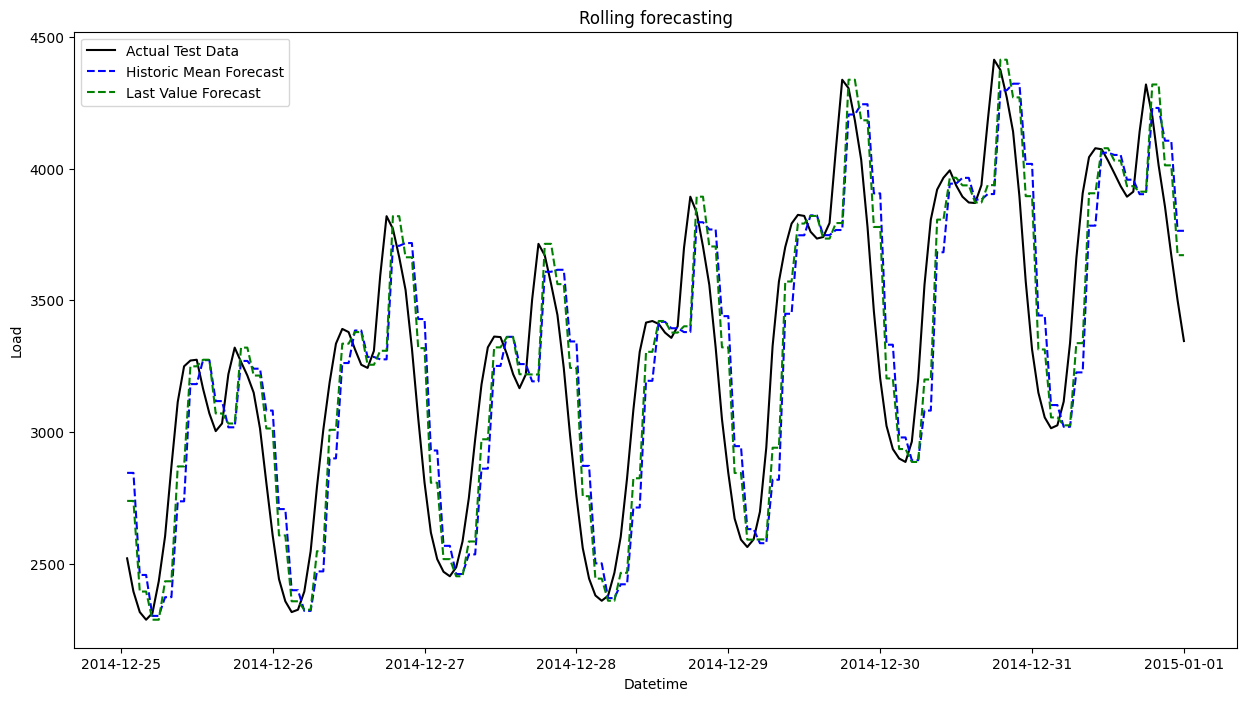

In [23]:
# Calculate MSE for pred_mean
mse_arima = mean_squared_error(test, pred_arima)
print("MSE for pred_arima:", mse_arima)


# Plotting actual test data
plt.figure(figsize=(15, 8))

plt.plot(test.index, test, label='Actual Test Data', color='black')

# Plotting forecasts
plt.plot(test.index, pred_mean, label='Historic Mean Forecast', linestyle='--', color='blue')
plt.plot(test.index, pred_last, label='Last Value Forecast', linestyle='--', color='green')
#plt.plot(test.index, pred_arima, label='Arima', linestyle='--', color='red')

# Customize the plot
plt.title('Rolling forecasting')
plt.xlabel('Datetime')
plt.ylabel('Load')
plt.legend()
plt.show()

In [16]:
# #this either takes too long or my pc crashes

# d = 0
# D = 0
# s = 24

# def evaluate_sarima(order, seasonal_order, data):
#     try:
#         model = pm.auto_arima(data, seasonal=True, m=s, suppress_warnings=True, order=order, seasonal_order=seasonal_order)
#         aic = model.aic()
#         return aic
#     except:
#         return float('inf')  # Return a large value for combinations that fail

# def grid_search_sarima(data, p_values, d, q_values, P_values, D, Q_values, s):
#     best_aic = float('inf')
#     best_params = None

#     # Generate all combinations of parameters
#     param_combinations = list(itertools.product(p_values,  q_values, P_values, Q_values))

#     for param_set in param_combinations:
#         order = (param_set[0], d, param_set[1])
#         seasonal_order = (param_set[2], D, param_set[3], s)
#         print(param_set)
#         aic = evaluate_sarima(order, seasonal_order, data)

#         if aic < best_aic:
#             best_aic = aic
#             best_params = param_set

#     return best_params, best_aic

# # Example usage:
# # Define the ranges for your parameters
# p_values = range(1, 4)
# q_values = range(1, 4)
# P_values = range(1, 4)
# Q_values = range(1, 4)

# # Perform grid search
# best_params, best_aic = grid_search_sarima(df['load'], p_values, d, q_values, P_values, D, Q_values, s)

# print("Best Parameters:", best_params)
# print("Best AIC:", best_aic)

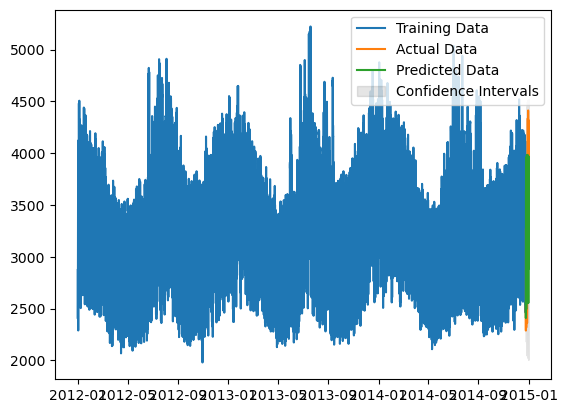

Mean Squared Error (MSE): 97926.82650669354
Mean Absolute Error (MAE): 281.53222171564784
Mean Percentage Error (MPE): -1.4508074723061541


In [17]:


p, d, q = 2, 0, 3
P, D, Q, s = 2, 0, 2, 24


# Create and fit the SARIMAX model
sarimax_model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
sarimax_result = sarimax_model.fit(disp=False, method='powell')

# Make predictions on the test set
forecast = sarimax_result.get_forecast(steps=len(test))

# Get predicted values and confidence intervals
predicted_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plotting the results
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Data')
plt.plot(test.index, predicted_values, label='Predicted Data')
plt.fill_between(test.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='k', alpha=0.1, label='Confidence Intervals')
plt.legend()
plt.show()

# Calculate Mean Squared Error (MSE)
mse_sarima_predict = mean_squared_error(test, predicted_values)
print(f'Mean Squared Error (MSE): {mse_sarima_predict}')

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test, predicted_values)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Mean Percentage Error (MPE)
# Note: MPE calculation may result in division by zero if the actual values are zero.
# It's advisable to handle such cases based on your specific requirements.
mpe = ((test - predicted_values) / test).mean() * 100
print(f'Mean Percentage Error (MPE): {mpe}')

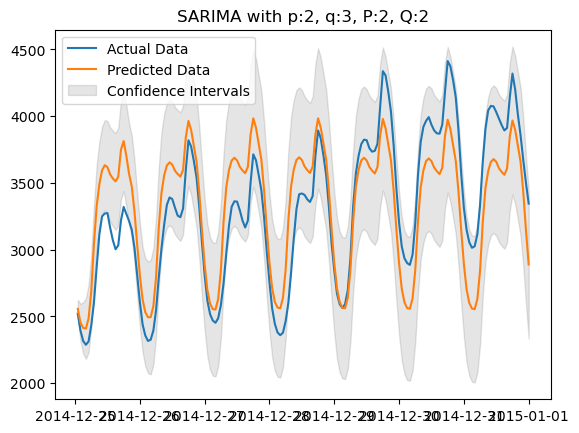

In [18]:
# Plotting the results
plt.plot(test.index, test, label='Actual Data')
plt.plot(test.index, predicted_values, label='Predicted Data')
plt.fill_between(test.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='k', alpha=0.1, label='Confidence Intervals')
plt.legend()
plt.title(f'SARIMA with p:{p}, q:{q}, P:{P}, Q:{Q}')
plt.show()

### SARIMAX (Temperature as exogenous)

In [19]:
#sarimax com temperatura como variável exógena

# Assuming you have a column 'temperature' in your DataFrame 'df'
exog_variable = df['T']

# Define the SARIMAX model with exogenous variable
sarimax_model_exog = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s), exog=exog_variable[:train_size])
sarimax_result_exog = sarimax_model_exog.fit(disp=False, method="powell")

# Make predictions on the test set with exogenous variable
forecast_exog = sarimax_result_exog.get_forecast(steps=len(test), exog=exog_variable[train_size:])

# Get predicted values and confidence intervals
predicted_values_exog = forecast_exog.predicted_mean
confidence_intervals_exog = forecast_exog.conf_int

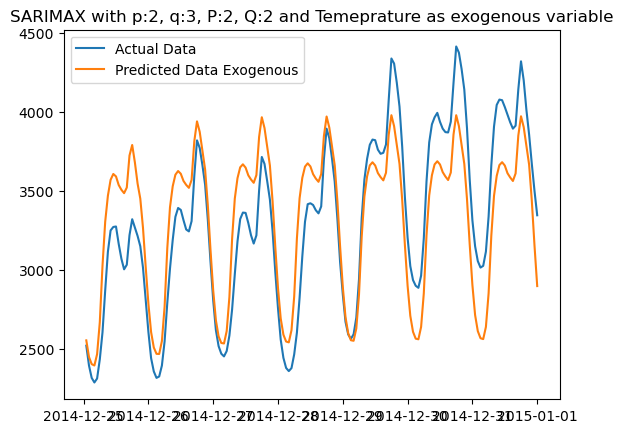

Mean Squared Error (MSE): 90594.81871888264
Mean Absolute Error (MAE): 268.90161940221486
Mean Percentage Error (MPE): -1.0812411942780789


In [20]:
# Plotting the results
plt.plot(test.index, test, label='Actual Data')
plt.plot(test.index, predicted_values_exog, label='Predicted Data Exogenous')
plt.legend()
plt.title(f'SARIMAX with p:{p}, q:{q}, P:{P}, Q:{Q} and Temeprature as exogenous variable')
plt.show()

# Calculate Mean Squared Error (MSE)
mse_sarimax_predict = mean_squared_error(test, predicted_values_exog)
print(f'Mean Squared Error (MSE): {mse_sarimax_predict}')

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test, predicted_values_exog)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Mean Percentage Error (MPE)
# Note: MPE calculation may result in division by zero if the actual values are zero.
# It's advisable to handle such cases based on your specific requirements.
mpe = ((test - predicted_values_exog) / test).mean() * 100
print(f'Mean Percentage Error (MPE): {mpe}')

### MSE Comparison (Normal Predict)

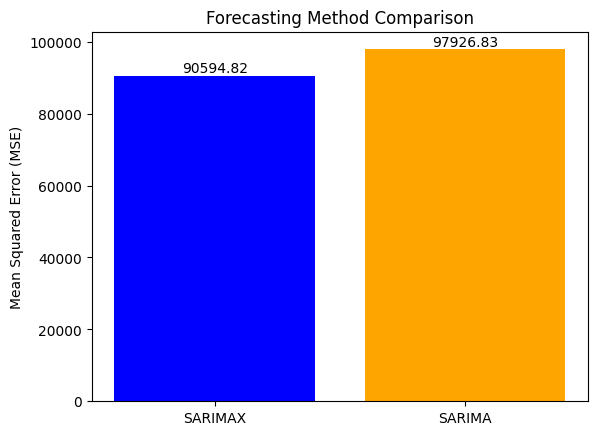

In [22]:

mse_sarimax_predict = 90594.81871888264
mse_sarima_predict = 97926.82650669354

variables = [mse_sarimax_predict, mse_sarima_predict]
methods = ['SARIMAX', 'SARIMA']

# Create bar plot
plt.bar(methods, variables, color=['blue', 'orange'])

# Add text labels on top of the bars
for i, v in enumerate(variables):
    plt.text(i, v + 2000, f'{v:.2f}', color='black', ha='center', va='center')

# Customize the plot
plt.title('Forecasting Method Comparison')
plt.ylabel('Mean Squared Error (MSE)')

# Show the plot
plt.show()

### Rolling Forecast


In [22]:
exog_variable = df['T']


def rolling_forecast(function: str, df: pd.DataFrame, train_len: int, horizon: int, window: int) -> list:
    if (function.lower() == 'sarima'):
        total_len = train_len + horizon
        pred_SARIMA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(p,0,q), seasonal_order=(P, D, Q, s))
            res = model.fit(disp=False, method='Powell')
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
            
        return pred_SARIMA

    elif (function.lower() == 'sarimax'):
        total_len = train_len + horizon
        pred_SARIMAX = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(p,0,q), seasonal_order=(P, D, Q, s), exog=exog_variable[:i])
            res = model.fit(disp=False, method='Powell')
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX
    
    elif function.lower() == 'mean':
        pred_mean = []

        for i in range(train_len, len(df) + 1, window):
            mean_value = df[i - window:i].mean()  # Replace 'your_column_name' with the actual column name
            pred_mean.extend([mean_value] * window)

        return pred_mean[:168]  # Ensure only 168 predictions are returned

    elif function.lower() == 'last':
        pred_last = []

        for i in range(train_len, len(df) + 1, window):
            last_value = df[i - 1:i].iloc[-1]  # Replace 'your_column_name' with the actual column name
            pred_last.extend([last_value] * window)

        return pred_last[:168]  # Ensure only 168 predictions are returned

pred_last = rolling_forecast('last', df['load'], len(train), len(test), 2 )
pred_mean = rolling_forecast('mean', df['load'], len(train), len(test), 2 )
pred_SARIMA = rolling_forecast('sarima', df['load'], len(train), len(test), 2 )
pred_SARIMAX = rolling_forecast('sarimax', df['load'], len(train), len(test), 2 )

ValueError: Out-of-sample operations in a model with a regression component require additional exogenous values via the `exog` argument.

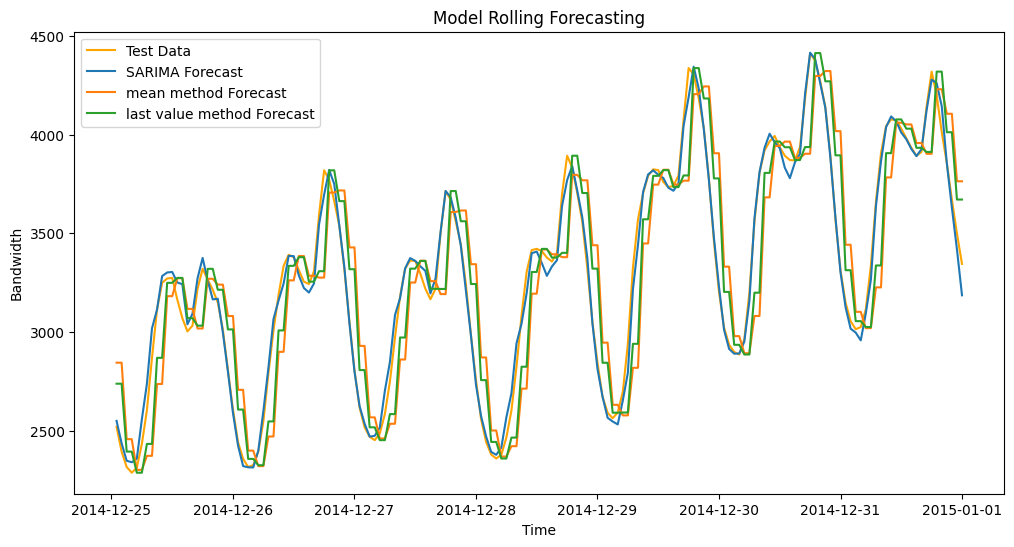

In [ ]:
# Plot the training data, test data, and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(test, label='Test Data', color='orange')
plt.plot(test.index, pred_SARIMA, label='SARIMA Forecast')
plt.plot(test.index, pred_mean, label='mean method Forecast')
plt.plot(test.index, pred_last, label='last value method Forecast')
plt.plot(test.index, pred_SARIMAX, label='SARIMAX Forecast')


plt.title('Model Rolling Forecasting')
plt.xlabel('Time')
plt.ylabel('Bandwidth')
plt.legend()
plt.show()

2932.364403079515 90486.63095238095 60103.06547619047


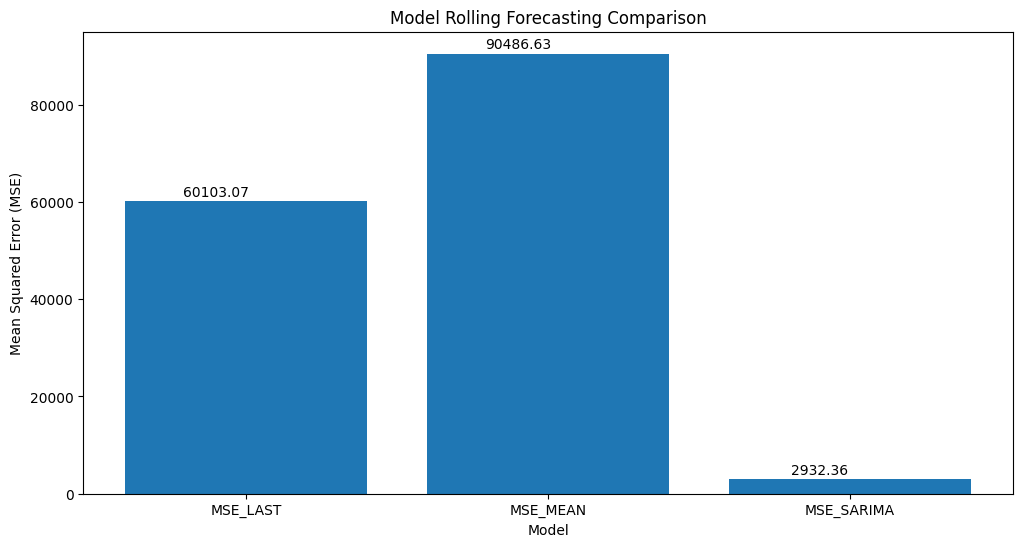

In [18]:

mse_sarima = 2932.364403079515
mse_mean = 90486.63095238095
mse_last = 60103.06547619047

print(mse_sarima, mse_mean, mse_last)

# Plot the training data, test data, and forecasted values
plt.figure(figsize=(12, 6))

# Posições das barras no eixo x
positions = [1, 2, 3]

# Alturas das barras
heights = [mse_last, mse_mean, mse_sarima]

# Adiciona as barras ao gráfico
bars = plt.bar(positions, heights, tick_label=['MSE_LAST', 'MSE_MEAN', 'MSE_SARIMA'])

# Adiciona os valores no topo das barras
for bar, height in zip(bars, heights):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 1000,
             f'{height:.2f}', ha='center', color='black')

plt.title('Model Rolling Forecasting Comparison')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.show()